# Windy Hike around the Pit

You and your mother want to find your way out of a hike where you encounter a deep crevasse. You equally desire to spend time in the bar at the exit, but she is more prudent than you. 
Which way are you both going to choose?

Note that you cannot fall "outside of the rectangle".

In [1]:
import numpy as np
import matplotlib.pyplot as plt #%matplotlib inline

In [2]:
class Hike:
    
    width = 20
    height = 10
    pitStartX = 4
    pitEndX = 16
    pitStartY = 1
    pitEndY = 5
    wind = 0.05

    
    width = 4
    height = 3
    pitStartX = 1
    pitEndX = 3
    pitStartY = 1
    pitEndY = 2
    wind = 0.05

    
    width = 10
    height = 6
    pitStartX = 3
    pitEndX = 7
    pitStartY = 1
    pitEndY = 3
    wind = 0.05    

    
    moveDirections = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    def pos2state(self, pos):
        if pos[0] < 0 or pos[0] >= self.width or pos[1] < 0 or pos[1] >= self.height:
            return -1 # invalid state
        if pos[0] >= self.pitStartX and pos[0] < self.pitEndX and pos[1] >= self.pitStartY and pos[1] < self.pitEndY:
            return self.nbStates - 1 # fallen in the sea
        return self.height * pos[0] + pos[1]
        
    def state2pos(self, s):
        return ((s // self.height, s % self.height))

    def nextState(self, s, a):
        p = self.state2pos(s)
        if s == self.nbStates - 1 or p == self.barPos:
            return(s) #once in the sea or in the bar, does not move
        #if p[0] >= self.pitStartX and p[0] < self.pitEndX and p[1] >= self.pitStartY and p[1] < self.pitEndY:
        #    return(s) # should not be necessary
        m = self.moveDirections[a]
        p2 = (p[0] + m[0], p[1] + m[1])
        ns = self.pos2state(p2)
        if ns < 0: # invalid move: stay 
            return s
        return ns

    def makeTransitionKernel(self):
        self.transitionKernel = [np.zeros((self.nbStates, self.nbStates)) for _ in range(self.nbActions)] 
        for a in range(self.nbActions):
            for s in range(self.nbStates):
                for b in range(self.nbActions):
                    ns = self.nextState(s, b)
                    if a == b:
                        self.transitionKernel[a][s, ns] += 1 - self.wind * (self.nbActions - 1)
                    else: 
                        self.transitionKernel[a][s, ns] += self.wind
    
    def __init__(self):
        self.entryPos = (0, 0)
        self.barPos = (self.width-1, 0)
        self.nbStates = self.width * self.height + 1 # last one = sink (when agent falls)
        self.nbActions = len(self.moveDirections)
        self.makeTransitionKernel()

    def startGame(self):
        return self.pos2state(self.entryPos)

    def reward(self, s, a, s2):
        return 1.0 if s2 == self.pos2state(self.barPos) else 0.0
    
    def transition(self, state, action): 
        if np.random.rand() < 4 * self.wind:
            a = np.random.choice(4)
        else:
            a = action
        ns = self.nextState(state, a)
        return((ns, self.reward(state, action, ns)))

    def plot(self):
        plt.plot([0, self.width, self.width, 0, 0], [0, 0, self.height, self.height, 0])
        plt.plot([self.pitStartX, self.pitStartX, self.pitEndX, self.pitEndX, self.pitStartX], [self.pitStartY, self.pitEndY, self.pitEndY, self.pitStartY, self.pitStartY], color = "red")
        (i,j) = self.entryPos 
        plt.plot([i, i+1, i+1, i, i], [j, j, j+1, j+1, j], color="k")
        (i,j) = self.barPos 
        plt.plot([i, i+1, i+1, i, i], [j, j, j+1, j+1, j], color='g')
        plt.axis('off')

    def plotPolicy(self, pi):
        T = pi.shape[1]
        for t in range(T):
            for i in range(self.width):
                for j in range(self.height):
                    s = self.pos2state((i,j))
                    if s<self.nbStates-1:
                        m = self.moveDirections[pi[s, t]]
                        if t==0 or pi[self.pos2state((i,j)), t] != pi[self.pos2state((i,j)), t-1]:
                            plt.arrow(i+0.5, j+0.5, 0.3*m[0], 0.3*m[1], length_includes_head=True, head_width=0.1, head_length=0.1, alpha = (T-1-t)/T)
                            if t>0:
                                plt.text(i+0.6, j+0.6, str(t), fontsize = 5)

    def plotDecisionRule(self, dr):
        for i in range(self.width):
            for j in range(self.height):
                s = self.pos2state((i,j))
                if s<self.nbStates-1:
                     m = self.moveDirections[dr[self.pos2state((i,j))]]
                     plt.arrow(i+0.5, j+0.5, 0.3*m[0], 0.3*m[1], length_includes_head=True, head_width=0.1, head_length=0.1)
    
    def plotValue(self, V):
        for i in range(self.width):
            for j in range(self.height):
                s = self.pos2state((i,j))
                if s<self.nbStates-1:
                    plt.text(i+0.1, j+0.1, str(int(np.round(V[s, 0]))), fontsize = 8, color = "blue")
                     


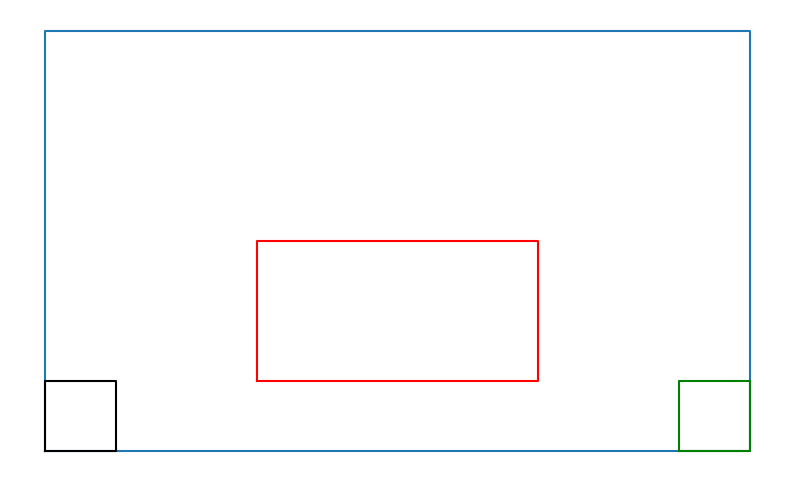

In [3]:
hike = Hike()
plt.figure(figsize=(hike.width,hike.height))
hike.plot()

In [4]:
class randomAgent:    
    def __init__(self):
        pass

    def startGame(self, hike):
        self.hike = hike
    
    def step(self, s, r):
        return np.random.choice(self.hike.nbActions)

In [5]:
def play(environment, agent, horizon):
    agent.startGame(environment)
    s = environment.startGame()
    W = 0
    r = 0
    for t in range(horizon):
        action = agent.step(s, r)
        s, r = environment.transition(s, action)
        W += r
    return W

In [6]:
hike = Hike()
agent = randomAgent()
T = 10
play(hike, agent, T)

0.0

In [7]:
def valueIteration(envir, T):
    V = -np.inf * np.ones((envir.nbStates, T+1))
    V[:, T] = 0
    pi = np.zeros((envir.nbStates, T), int)
    for t in range(T-1, -1, -1):
        for s in range(envir.nbStates):
            for a in range(envir.nbActions):
                v = np.dot(envir.transitionKernel[a][s, :], [envir.reward(s, a, ns) + V[ns, t+1] for ns in range(envir.nbStates)])
                if v > V[s, t]:
                    V[s, t] = v
                    pi[s, t] = a # could have a rule to resolve ties - here action with lowest index is chosen
    return((V, pi))


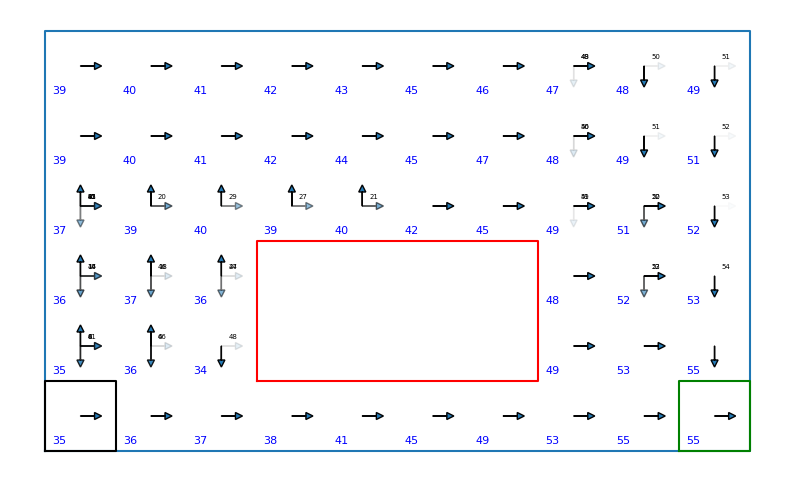

In [8]:
T = 55 # T = 65
V, pi = valueIteration(hike, T)
plt.figure(figsize=(hike.width,hike.height))
hike.plot()
hike.plotPolicy(pi)
#hike.plotDecisionRule(pi[:, 0])
hike.plotValue(V)

In [9]:
class PolicyAgent:    
    def __init__(self, policy):
        self.policy = policy
        self.t = 0

    def startGame(self, hike):
        self.hike = hike
        self.t = 0
    
    def step(self, s, r):
        return self.policy[s, self.t]
        self.t += 1

In [10]:
class VIAgent(PolicyAgent) :
    def __init__(self, envir, T):
        V, pi = valueIteration(envir, T)
        PolicyAgent.__init__(self, pi) 

In [11]:
agent = VIAgent(hike, T)
play(hike, agent, T)

46.0

34.9369 44.0 35.0 0.2001 320.33271839


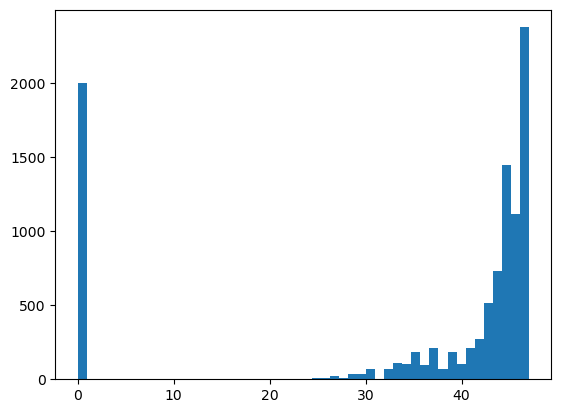

In [12]:
def evaluate(envir, agent, horizon):
    res = []
    N = 10000
    for _ in range(N):
        res.append(play(envir, agent, horizon))
    return res

res = evaluate(hike, agent, T)
print(np.mean(res), np.median(res), np.quantile(res, 0.25), np.mean([x==0 for x in res]), np.var(res))
plt.hist(res, 50)
plt.show()

# Computing statistics for a given policy

Computes $V[s] = E\left[g\left(\sum_{t=1}^T h(S_t, A_t, S_{t+1})  + f(S_{T+1})\right) | S_1 = s\right]$

You should provide $f$ and a function $\phi$ such that 
if $V(t, s) = E\left[g\left(\sum_{k=t+1}^T h(S_k, A_t, S_{k+1}) + f(S_{T+1})\right) | S_{t+1} = s\right] $,
$V(t, s)  = \sum_{ns} P(ns|s,a) \phi\left(s, a, ns, V(t+1, ns)\right)$ 

In [13]:
def backwardInduction(envir, T, policy, phi, final):
    V = [final(s) for s in range(envir.nbStates)]
    for t in range(T-1, -1, -1):
        pV = []
        for s in range(envir.nbStates):
            a = policy[s, t]
            p = envir.transitionKernel[a][s, :]
            v = p[0] * phi(s, a, 0, V[0])
            for ns in range(1, envir.nbStates):
                v += p[ns] * phi(s, a, ns, V[ns])
            pV.append(v)
        V = pV.copy()
    return(V)

# Verification with the usual expectation:
phi = lambda s, a, ns, v: hike.reward(s, a, ns) + v
final = lambda s: 0.
V = backwardInduction(hike, T, pi, phi, final)
V[hike.pos2state(hike.entryPos)]

35.039823522979525

In [14]:
# Expectation of the time spent in a state between times 2 and T+1
def timeInState(envir, policy, state):
    phi = lambda s, a, ns, v: float(ns == state) + v
    final = lambda s: 0.
    V = backwardInduction(envir, T, policy, phi, final)
    return V[envir.pos2state(envir.entryPos)]

[timeInState(hike, pi, s) for s in [hike.nbStates-1, hike.pos2state(hike.entryPos), hike.pos2state(hike.barPos)]]

[9.780581336552396, 0.1772220950265372, 35.039823522979525]

In [15]:
# Probability to visit a state at time t>1
def probaVisitState(envir, policy, state):
    phi = lambda s, a, ns, v: (ns != state) * v
    final = lambda s: float(s != state)
    V = backwardInduction(envir, T, policy, phi, final)
    return 1-V[envir.pos2state(envir.entryPos)]

[probaVisitState(hike, pi, s) for s in [hike.nbStates-1, hike.pos2state(hike.entryPos), hike.pos2state(hike.barPos)]]

[0.19821805103699597, 0.15040928378250662, 0.8017819475151352]

In [16]:
def varianceCumulatedReward(envir, policy):
    phi = lambda s, a, ns, v: np.array([envir.reward(s, a, ns) + v[0], envir.reward(s, a, ns)**2 + 2 * envir.reward(s, a, ns) * v[0] + v[1]])
    final = lambda s: np.array([0.,0.])
    V = backwardInduction(envir, T, pi, phi, final)
    v = V[envir.pos2state(envir.entryPos)]
    return v[1] - v[0]**2

varianceCumulatedReward(hike, pi)

317.90631483827383

# Distributional approach

A distribution is represented as a pair p,v of numpy vectors of the same size, where $p[i]$ is the probability of $v[i]$

[1.6199999999999999, 3.7956000000000003, 1.0, 5.0]

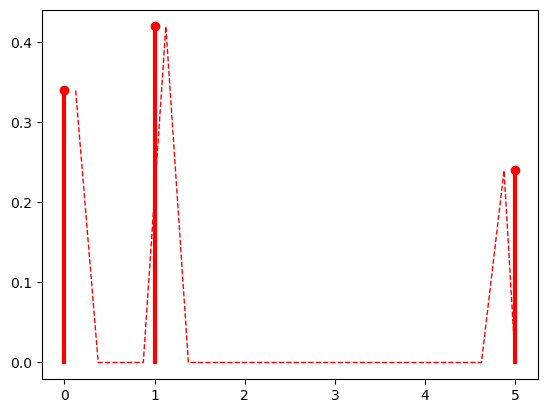

In [17]:
def translate(d,x):
    return((d[0], d[1]+x))

def mixture(q, D):
    p = np.concatenate([q[i] * D[i][0] for i in range(len(q))])
    v = np.concatenate([d[1] for d in D])
    return clean((p, v))

def clean(d): # sorts x, removes 0 probabilities
    n = len(d[0])
    z = sorted([(d[1][i], i) for i in range(n)])
    vf = []
    pf = []
    for i in range(n):
        if d[0][z[i][1]] < 1e-14:
            continue
        if (len(vf)==0 or abs(vf[-1] - z[i][0]) > 1e-12):
            vf.append(z[i][0])
            pf.append(d[0][z[i][1]])
        else:
            pf[-1] += d[0][z[i][1]]
    
    return(np.array(pf), np.array(vf))    

def mean(d):
    return(np.dot(d[0], d[1]))

def var(d):
    return(np.dot(d[0], d[1]**2) - mean(d)**2)
    
def quantile(d, q):
    i = 0
    cp = d[0][0]
    while i<len(d[1])-1 and cp < q:
        i += 1
        cp += d[0][i]
    return d[1][min(i, len(d[1])-1)]

def median(d):
    return quantile(d, 0.5)

def plotDistrib(d, **kwargs):
    plt.scatter(d[1], d[0], **kwargs)
    for i in range(len(d[0])):
        plt.plot([d[1][i], d[1][i]], [0, d[0][i]], linewidth=3, **kwargs)
    a = d[1][0]
    b = d[1][-1]
    N = 20
    i = 0
    his = []
    for j in range(N):
        cp = 0
        while d[1][i] < a + (b-a)*(j+1)/N:
            cp += d[0][i]
            i = i+1
        his.append(cp)
    his[-1] += d[0][-1]
    plt.plot([a + (b-a)*(j+0.5)/N for j in range(N)] + [b], his+ [0], linewidth=1, linestyle='dashed', **kwargs)
    
p1 = np.array([0.4, 0.6])
v1 = np.array([0, 1])
p2 = np.array([0.3, 0.3, 0.4])
v2 = np.array([0., 1, 5])

d = mixture([0.4, 0.6], [(p1,v1), (p2,v2)])
plotDistrib(d, color="red")
[mean(d), var(d), quantile(d, 0.5), quantile(d, 0.8)]

In [18]:
def distribBI(envir, T, policy):
    dirac0 = (np.array([1.]), np.array([0.]))
    V = [dirac0 for s in range(envir.nbStates)]
    for t in range(T-1, -1, -1):
        pV = []
        for s in range(envir.nbStates):
            a = policy[s, t]
            p = envir.transitionKernel[a][s, :]
            v = mixture(p, [translate(V[ns], envir.reward(s, a, ns)) for ns in range(envir.nbStates)])
            pV.append(v)
        V = pV.copy()
    return(V)

V = distribBI(hike, T, agent.policy)
law = V[hike.pos2state(hike.entryPos)]

35.03982352297952 317.90631483827406 [0.0, 35.0, 44.0, 46.0, 47.0] 0.1982180524848648
34.9368999999997 320.3327183900069 [0.0, 35.0, 44.0, 46.0, 47.0] 0.20009999999999428
[0.19821805103699597, 0.8017819475151352]


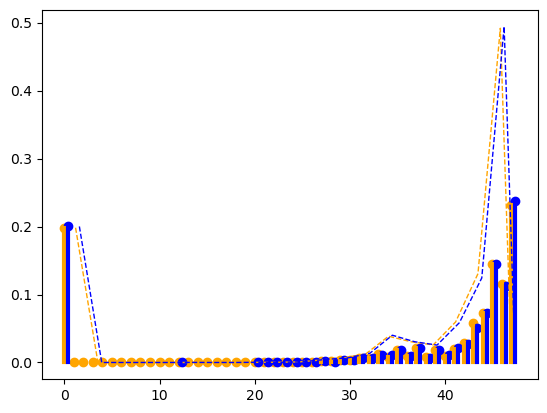

In [19]:
plotDistrib(law, color="orange")

n = len(res)
empiricalLaw = mixture([1.0], [(np.ones(n)/n, res)])# to get a normalized form 
d = translate(empiricalLaw, 0.4) # shift a bit for the plot 
plotDistrib(d, color="blue")
print(mean(law), var(law), [quantile(law, i/4) for i in range(5)], law[0][0])
print(mean(empiricalLaw), var(empiricalLaw), [quantile(empiricalLaw, i/4) for i in range(5)], empiricalLaw[0][0])
print([probaVisitState(hike, pi, s) for s in [hike.nbStates-1, hike.pos2state(hike.barPos)]])


In [20]:
empiricalLaw

(array([2.001e-01, 1.000e-04, 2.000e-04, 1.000e-04, 1.000e-04, 1.000e-04,
        3.000e-04, 7.000e-04, 1.200e-03, 2.100e-03, 1.200e-03, 3.400e-03,
        3.300e-03, 6.700e-03, 7.000e-03, 1.100e-02, 1.060e-02, 1.850e-02,
        9.400e-03, 2.110e-02, 6.900e-03, 1.870e-02, 1.050e-02, 2.080e-02,
        2.730e-02, 5.130e-02, 7.300e-02, 1.447e-01, 1.119e-01, 2.377e-01]),
 array([ 0., 12., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
        31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
        44., 45., 46., 47.]))

In [21]:
law

(array([1.98218052e-01, 1.22924370e-09, 2.02363649e-09, 3.94715939e-09,
        6.42315141e-09, 1.25898695e-08, 2.02229733e-08, 3.98585896e-08,
        6.30839481e-08, 1.25015666e-07, 1.94466129e-07, 3.87552965e-07,
        5.90807502e-07, 1.18421973e-06, 1.76364880e-06, 3.55582942e-06,
        5.15651043e-06, 1.04583657e-05, 1.47174025e-05, 3.00346661e-05,
        4.08388508e-05, 8.39491125e-05, 1.09536145e-04, 2.27201071e-04,
        2.81955121e-04, 5.90089321e-04, 6.88742449e-04, 1.45294862e-03,
        1.57490515e-03, 3.33149596e-03, 3.30804374e-03, 6.92102679e-03,
        6.12855492e-03, 1.19483157e-02, 8.64894150e-03, 1.80114104e-02,
        9.42334524e-03, 2.11095424e-02, 7.64002753e-03, 1.82164458e-02,
        1.02226666e-02, 2.01346223e-02, 2.92760414e-02, 5.85124014e-02,
        7.21554910e-02, 1.44249672e-01, 1.15808473e-01, 2.31616946e-01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.

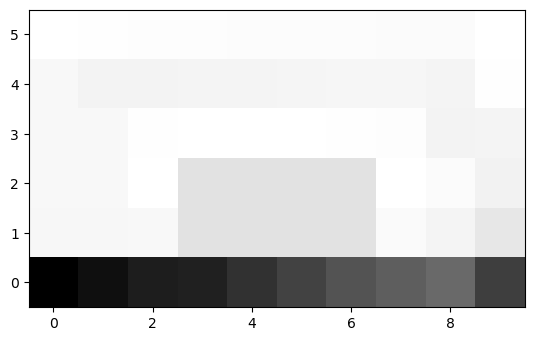

In [22]:
Pvisit = np.zeros((hike.width, hike.height))
for i in range(hike.width):
    for j in range(hike.height):
        s = hike.pos2state((i,j))
        if s>=0:
            Pvisit[i,j] = probaVisitState(hike, pi, s)
Pvisit[hike.entryPos[0], hike.entryPos[1]]=1
plt.imshow(np.transpose(Pvisit), origin = "lower", cmap='Greys', interpolation = None)

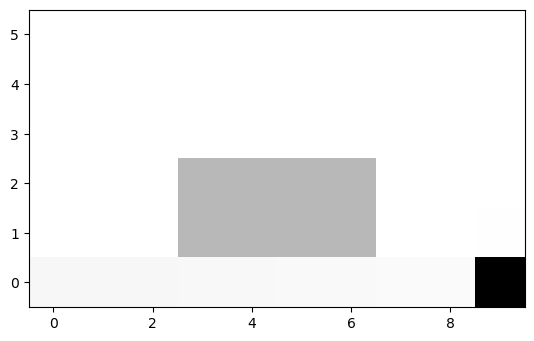

In [23]:
timeSpent = np.zeros((hike.width, hike.height))
for i in range(hike.width):
    for j in range(hike.height):
        s = hike.pos2state((i,j))
        if s>=0:
            timeSpent[i,j] = timeInState(hike, pi, s)
timeSpent[hike.entryPos[0], hike.entryPos[1]]+=1
plt.imshow(np.transpose(timeSpent), origin = "lower", cmap='binary', interpolation = None)

## Evaluation: 

Upload into folder https://plmbox.math.cnrs.fr/u/d/a3e360fc96684fb78df4/ a file <Yourname.py> containing a class MyAgent respecting the above template (it should have methods startGame and step). 
MyAgent should also have a method called "setObjective" which permits to specify which beta-mean or which quantile is to be optimized (see the first line of functions evaluateBetaMean and evaluateQuantile). 

Your agent will be evaluated in a variety of environments :
  * for different values of beta (function evaluateBetaMean)
  * for different values of quantiles (function evaluateQuantile)

The computational cost of your method will be taken into account.

In [24]:
# Baseline: 
class MyAgent(VIAgent):
    def setObjective(self, nature, parameter): 
        pass
        
def betaMean(x, beta):
    if beta==0:
        return np.mean(x)
    else:
        return np.log(np.mean(np.exp(beta * x))) / beta

def evaluateBetaMean(envir, agent, horizon, beta):
    agent.setObjective("BetaMean", beta)
    res = []
    N = 10000
    for _ in range(N):
        res.append(play(envir, agent, horizon))
    return betaMean(res, beta)

def evaluateQuantile(envir, agent, horizon, q):
    agent.setObjective("Quantile", q) 
    res = []
    N = 10000
    for _ in range(N):
        res.append(play(envir, agent, horizon))
    return np.quantile(res, q)


In [25]:
myAgent = MyAgent(hike, T)
print("2-mean: ", evaluateBetaMean(hike, myAgent, T, 2))
print("15% quantile: ", evaluateQuantile(hike, myAgent, T, 0.15))

2-mean:  22.89368939261704
15% quantile:  0.0
